# Store Sales 
#### Use time series forecating and machine learning to predict grocery sales. 

Predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. 

Original dataset and information can be found here on Kaggle:
https://www.kaggle.com/c/store-sales-time-series-forecasting/code?competitionId=29781&sortBy=dateRun&tab=profile

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics

'''
oil=r'/kaggle/input/store-sales-time-series-forecasting/oil.csv'
sample=r'/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv'
event=r'/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv'
stores=r'/kaggle/input/store-sales-time-series-forecasting/stores.csv'
train=r'/kaggle/input/store-sales-time-series-forecasting/train.csv'
test=r'/kaggle/input/store-sales-time-series-forecasting/test.csv'
transaction=r'/kaggle/input/store-sales-time-series-forecasting/transactions.csv'
'''

#COMPUTER FILES:
train=r'C:\Users\sschm\Desktop\kaggle\storeSales\train.csv'
stores=r'C:\Users\sschm\Desktop\kaggle\storeSales\stores.csv'
transaction=r'C:\Users\sschm\Desktop\kaggle\storeSales\transactions.csv'
event=r'C:\Users\sschm\Desktop\kaggle\storeSales\holidays_events.csv'


## Train Dataset 
The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.

In [2]:
trainDF=pd.read_csv(train)
trainDF.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Transactions 
The original transaction dataset is 83488 rows × 3 columns. There was no missing data.

In [3]:
tDF=pd.read_csv(transaction)
tDF.drop_duplicates() 
tDF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False) #no missing data

#Feature three new columns with year, month, and day:
tDF['year']=tDF['date'].apply(lambda x: int(str(x)[:4])) #first four
tDF['month']=tDF['date'].apply(lambda x: int(str(x)[5:7])) #five and six
tDF['day']=tDF['date'].apply(lambda x: int(str(x)[-2:])) # last two

#Verify the new columns are setup correctly:
#print(tDF['day'].unique()) # Correctly prints numbers 1 to 31
#print(tDF['month'].unique()) # [ 1  2  3  4  5  6  7  8  9 10 11 12]
#print(tDF['year'].unique()) # [2013 2014 2015 2016 2017]

tDF.head() 

,date,store_nbr,transactions,year,month,day
0,2013-01-01,25,770,2013,1,1
1,2013-01-02,1,2111,2013,1,2
2,2013-01-02,2,2358,2013,1,2
3,2013-01-02,3,3487,2013,1,2
4,2013-01-02,4,1922,2013,1,2


In [4]:
tDF.dtypes

date            object
store_nbr        int64
transactions     int64
year             int64
month            int64
day              int64
dtype: object

## Yearly Sales
The graph clearly shows that sales went down in 2017. This is not a good trend. Prior to 2017, sales were mostly flat from years 2013 to 2016. There is a negative correlation, -.57 which verifies that sales are decreasing.  

   year  transactions
0  2013      29107173
1  2014      30006929
2  2015      31312370
3  2016      31052337
4  2017      20000136


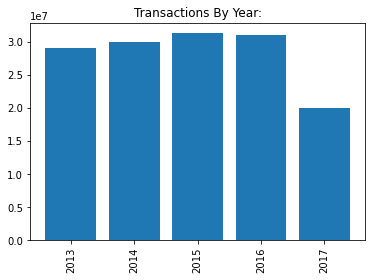

-0.5752  is the correlations between year and transactions


In [5]:
yearGb=tDF.groupby('year')['transactions'].sum().reset_index()
print(yearGb)
x=yearGb['year']
y=yearGb['transactions']
plt.title("Transactions By Year:")
plt.xticks(rotation=90)
plt.bar(x,y)
plt.show()

yearCorr=x.corr(y).round(4)
print(yearCorr, " is the correlations between year and transactions")

## Monthly Sales 
Sales are the least in September, October, and November. The rest of the months are fairly similiar. Surprisingly, December did not have the highest sales as normally that is when stores have most of their sales from Christmas.

    month  transactions
0       1      12156198
1       2      11707934
2       3      12917913
3       4      12633531
4       5      13112679
5       6      12482179
6       7      12827206
7       8      11545571
8       9       9811819
9      10      10048234
10     11       9877873
11     12      12357808


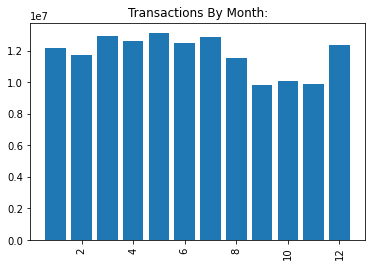

-0.545  is the correlations between year and transactions


In [6]:
monthGb=tDF.groupby('month')['transactions'].sum().reset_index()
print(monthGb)
x=monthGb['month']
y=monthGb['transactions']
plt.title("Transactions By Month:")
plt.xticks(rotation=90)
plt.bar(x,y)
plt.show()

monthCorr=x.corr(y).round(4)
print(monthCorr, " is the correlations between year and transactions")

## Extra: Multivariate time series forecasting
A more complex way to do times series forecasting is using the datetime as dt import. Since the transaction dataset did not have minutes and seconds there was no need to use this more complicated full function for all the new columns you can make from a datetime. In this specific sales case, we will only be needing month, year, and day since time was not provided.

The date column is currently an object but needs to be chnaged to a datetime datatype column. This will help later when we use the create_time_features later. Dates are initially as 2013-01-02 format so wo will keep that consistent. Missing values must be deleted one last time in the event there was an coerce error that occurs. Finally, we must transform each date to a datetime that can be regonized by using .dt for the create_time_features function to work. Here is a good SO article on how to solve this issue:
https://stackoverflow.com/questions/56698521/can-only-use-dt-accessor-with-datetimelike-values/56698574

In [7]:
import datetime as dt
from datetime import datetime

# ADD time features to our model:
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    #df['sin_day'] = np.sin(df['dayofyear'])
    #df['cos_day'] = np.cos(df['dayofyear'])
    #df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y
    
    return X

## Stores Dataset

In [8]:
stores=pd.read_csv(stores)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Events

In [9]:
event=pd.read_csv(event)
event.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## References
Most of these resources are on Time Series:
1. https://www.kaggle.com/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide
2. https://www.kaggle.com/ilyakondrusevich/54-stores-54-models
3. https://github.com/jiwidi/time-series-forecasting-with-python/blob/master/02-Forecasting_models.ipynb